In [60]:
import frgtools.misc as frgm
import frgtools.jv as jv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
# style.use('ggplot') or plt.style.use('ggplot')
import pandas as pd
import os
from scipy.optimize import curve_fit
from tqdm import tqdm
import seaborn as sns

In [61]:
from importlib import reload
reload(jv)

<module 'frgtools.jv' from '/Users/deniz/Documents/GitHub/Python-Utilities/FrgTools/frgtools/jv.py'>

# Loading Raw Data File

In [62]:
fids = frgm.listdir('Data')

Files in 'Data':
0:20200312_Optimization.txt
1:20200312_Optimization.csv
2:Icon


In [63]:
data = jv.load_tracer(fids[0])
df = pd.DataFrame(data)

In [64]:
df.head()

,id,device,curvetype,area,date,time,v,i,p,j,direction,voc,jsc,ff,pce,vmpp
0,(1 of 2),C5SAED2_P1_S1,illuminated,0.07,3/12/2020,5:49:51 PM,"[-0.19873754, -0.19381961, -0.1836413568, -0.1...","[0.00153846448, 0.00154250023, 0.00153774783, ...","[-0.000305750646132579, -0.00029896679300351, ...","[0.021978064, 0.022035717571428567, 0.02196782...",reverse,1.035202,0.021897,0.695325,0.157615,0.851886
1,(2 of 2),C5SAED2_P1_S1,illuminated,0.07,3/12/2020,5:49:51 PM,"[-0.214153689, -0.202462888, -0.1933988712, -0...","[0.00159891889, 0.0015935856, 0.001587716662, ...","[-0.000342414378705285, -0.000322641942851213,...","[0.02284169842857143, 0.022765508571428568, 0....",forward,0.914714,0.021023,0.518887,0.099784,0.654879
2,(1 of 2),C5SAED2_P2_S1,illuminated,0.07,3/12/2020,5:50:25 PM,"[-0.205288765, -0.190382889, -0.1829226124, -0...","[0.00153625266, 0.00153351444, 0.001534547852,...","[-0.000315375411299365, -0.000291954909410417,...","[0.02194646657142857, 0.02190734914285714, 0.0...",reverse,1.034361,0.021671,0.694530,0.155682,0.833903
3,(2 of 2),C5SAED2_P2_S1,illuminated,0.07,3/12/2020,5:50:25 PM,"[-0.213724807, -0.203169147, -0.1932984842, -0...","[0.00159707417, 0.00158883642, 0.00158376725, ...","[-0.000341334368747935, -0.000322802540173934,...","[0.022815345285714283, 0.02269766314285714, 0....",forward,0.941193,0.021033,0.516741,0.102295,0.636039
4,(1 of 2),C5SAED2_P2_S2,illuminated,0.07,3/12/2020,5:51:59 PM,"[-0.203559405, -0.192030376, -0.1842162564, -0...","[0.00151826952, 0.00151499566, 0.001516576718,...","[-0.000309058040120836, -0.000290925186228168,...","[0.02168956457142857, 0.021642795142857142, 0....",reverse,1.036091,0.021617,0.676795,0.151586,0.814789


In [65]:
dfc = df.dropna() # note that this will drop dark curves as well
dfc = dfc[
    (dfc['ff'] <= 1) #nothing should have more than 100% fill factor
    & (dfc['pce'] >= 0.05) #removing data with pce below 5%, can be modified/removed depending on analysis
]

## Quick Summary Statistics

In [66]:
columns = ['pce', 'ff', 'jsc', 'voc', 'vmpp']
dfc[columns].describe()

,pce,ff,jsc,voc,vmpp
count,94.000000,94.000000,94.000000,94.000000,94.000000
mean,0.121716,0.594317,0.020931,0.966019,0.731339
std,0.028766,0.098801,0.001166,0.064745,0.095964
min,0.056365,0.380755,0.015138,0.745257,0.429388
25%,0.101412,0.535647,0.020649,0.941347,0.668469
50%,0.124076,0.604954,0.021300,0.979131,0.747897
75%,0.143720,0.676436,0.021581,1.015427,0.813614
max,0.171119,0.754215,0.022417,1.053931,0.861504


## Label experimental conditions

The specific functions here will be dependent on your experiment. The goal is to make a column for each condition varied in your dataset, with the condition marked per row. This will speed up data analysis, since the dataframe can be sliced/analyzed along experimental condtions

In [67]:
def pbexcess(name):
    if 'C5' in name:
        return 0.05
    elif 'C9' in name:
        return 0.09
    else:
        return np.nan
dfc['pb_excess'] = dfc['device'].apply(pbexcess)

In [68]:
def anneal(name):
    if 'SA' in name:
        return 'standard'
    elif 'EA' in name:
        return 'experimental'
    else:
        return np.nan
dfc['anneal'] = dfc['device'].apply(anneal)

In [69]:
def droptime(name):
    if 'SD' in name:
        return 'standard'
    elif 'ED' in name:
        return 'experimental'
    else:
        return np.nan
dfc['antisolventdrop'] = dfc['device'].apply(droptime)

In [70]:
def pixel(name):
    if '_P1_' in name:
        return 1
    elif '_P2_' in name:
        return 2
    elif '_P3_' in name:
        return 3
    else:
        return np.nan
dfc['pixel'] = dfc['device'].apply(pixel)

In [71]:
dfc.head()

,id,device,curvetype,area,date,time,v,i,p,j,direction,voc,jsc,ff,pce,vmpp,pb_excess,anneal,antisolventdrop,pixel
0,(1 of 2),C5SAED2_P1_S1,illuminated,0.07,3/12/2020,5:49:51 PM,"[-0.19873754, -0.19381961, -0.1836413568, -0.1...","[0.00153846448, 0.00154250023, 0.00153774783, ...","[-0.000305750646132579, -0.00029896679300351, ...","[0.021978064, 0.022035717571428567, 0.02196782...",reverse,1.035202,0.021897,0.695325,0.157615,0.851886,0.05,standard,experimental,1
1,(2 of 2),C5SAED2_P1_S1,illuminated,0.07,3/12/2020,5:49:51 PM,"[-0.214153689, -0.202462888, -0.1933988712, -0...","[0.00159891889, 0.0015935856, 0.001587716662, ...","[-0.000342414378705285, -0.000322641942851213,...","[0.02284169842857143, 0.022765508571428568, 0....",forward,0.914714,0.021023,0.518887,0.099784,0.654879,0.05,standard,experimental,1
2,(1 of 2),C5SAED2_P2_S1,illuminated,0.07,3/12/2020,5:50:25 PM,"[-0.205288765, -0.190382889, -0.1829226124, -0...","[0.00153625266, 0.00153351444, 0.001534547852,...","[-0.000315375411299365, -0.000291954909410417,...","[0.02194646657142857, 0.02190734914285714, 0.0...",reverse,1.034361,0.021671,0.694530,0.155682,0.833903,0.05,standard,experimental,2
3,(2 of 2),C5SAED2_P2_S1,illuminated,0.07,3/12/2020,5:50:25 PM,"[-0.213724807, -0.203169147, -0.1932984842, -0...","[0.00159707417, 0.00158883642, 0.00158376725, ...","[-0.000341334368747935, -0.000322802540173934,...","[0.022815345285714283, 0.02269766314285714, 0....",forward,0.941193,0.021033,0.516741,0.102295,0.636039,0.05,standard,experimental,2
4,(1 of 2),C5SAED2_P2_S2,illuminated,0.07,3/12/2020,5:51:59 PM,"[-0.203559405, -0.192030376, -0.1842162564, -0...","[0.00151826952, 0.00151499566, 0.001516576718,...","[-0.000309058040120836, -0.000290925186228168,...","[0.02168956457142857, 0.021642795142857142, 0....",reverse,1.036091,0.021617,0.676795,0.151586,0.814789,0.05,standard,experimental,2


In [125]:
Badcurve = ['C5SASD1_P3_S1', #removing specific erraneous curves
            'C9SASD2_P2_S2',
            'C9EASD1_P3_S1',
            'C5EASD1_P2_S1',
            'C9SASD1_P2_S1',
            'C5SASD2_P3_S1',
            'C9SASD2_P1_S1',
            ]

for n in range(0, len(Badcurve)):
    dfc = dfc[dfc.device !=Badcurve[n]]
dfc.reset_index(drop=True, inplace=True)

Save your cleaned up dataframe

In [126]:
dfc.to_csv('Cleaned_Dataframe.csv')

## Data Visualization

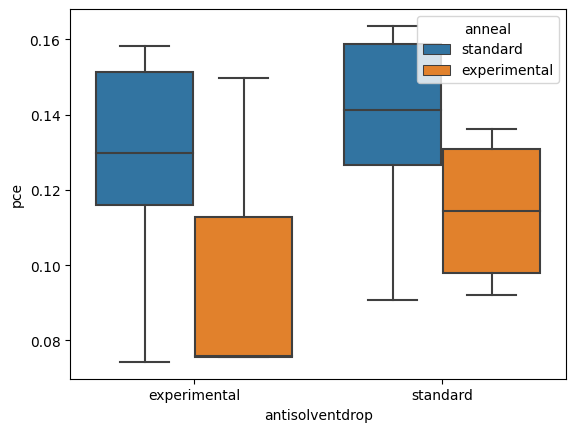

In [127]:
sns.boxplot(
    x = 'antisolventdrop',
    hue = 'anneal',
    y = 'pce',
    data = dfc[dfc['pixel'] == 2], #specifying pixel 2 (center pixel) for analysis
)

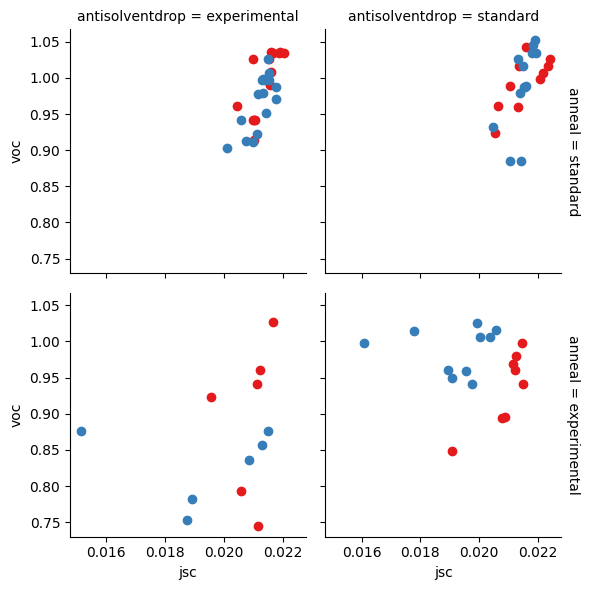

In [128]:
g = sns.FacetGrid(
    dfc, 
    col = "antisolventdrop", 
    row = "anneal", 
    hue = "pb_excess",
    palette = 'Set1',
    margin_titles = True
)

g = g.map(plt.scatter, "jsc", 'voc')

# Plotting the Subset

## New dataframe with subset

In [140]:
dfc_1 = dfc[
    (dfc['anneal'] == 'standard')
    & (dfc['pb_excess'] == 0.09 )
    & (dfc['antisolventdrop'] == 'standard')
    & (dfc['direction'] == 'forward')
    ]

dfc_1.reset_index(drop=True, inplace=True)

In [141]:
dfc_1.head()

,id,device,curvetype,area,date,time,v,i,p,j,direction,voc,jsc,ff,pce,vmpp,pb_excess,anneal,antisolventdrop,pixel
0,(2 of 2),C9SASD1_P3_S1,illuminated,0.07,3/12/2020,6:29:40 PM,"[-0.201070226, -0.196459886, -0.1847133598, -0...","[0.00153161431, 0.00152803107, 0.001530366638,...","[-0.000307962035456534, -0.000300196809816658,...","[0.021880204428571425, 0.021829015285714282, 0...",forward,1.034245,0.021937,0.754215,0.171119,0.861504,0.09,standard,standard,3
1,(2 of 2),C9SASD1_P3_S2,illuminated,0.07,3/12/2020,6:30:17 PM,"[-0.203563212, -0.196682495, -0.1851605104, -0...","[0.00150441218, 0.00150531723, 0.00150480283, ...","[-0.000306242975532722, -0.000296069548562889,...","[0.02149160257142857, 0.021504531857142857, 0....",forward,1.016676,0.021498,0.698018,0.152561,0.814556,0.09,standard,standard,3
2,(2 of 2),C9SASD1_P3_S2,illuminated,0.07,3/12/2020,6:32:53 PM,"[-0.211715011, -0.20422557, -0.1932996452, -0....","[0.00157928844, 0.00156839558, 0.001562740902,...","[-0.000334359069446773, -0.000320306481310981,...","[0.022561263428571426, 0.02240565114285714, 0....",forward,0.931536,0.020472,0.532536,0.101556,0.663555,0.09,standard,standard,3
3,(2 of 2),C9SASD2_P1_S2,illuminated,0.07,3/12/2020,6:34:58 PM,"[-0.214817541, -0.200190583, -0.19388453, -0.1...","[0.00161306714, 0.00160011485, 0.001593026872,...","[-0.000346515116482703, -0.000320327924688458,...","[0.023043816285714284, 0.022858783571428568, 0...",forward,0.987318,0.021505,0.554981,0.117836,0.747763,0.09,standard,standard,1
4,(2 of 2),C9SASD2_P2_S3,illuminated,0.07,3/12/2020,6:35:59 PM,"[-0.213014308, -0.203467051, -0.1947257946, -0...","[0.00160744293, 0.00159539569, 0.00158775268, ...","[-0.000342408343383442, -0.00032461045622241, ...","[0.022963470428571425, 0.022791366999999996, 0...",forward,0.988187,0.021589,0.573405,0.122328,0.710893,0.09,standard,standard,2


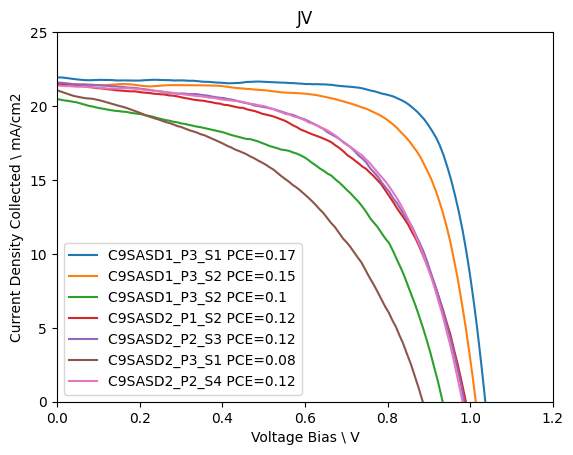

In [142]:
# filtered DataFrame to Plot
DF = dfc_1

mpl.rcParams.update(mpl.rcParamsDefault)
for q in range (0, len(dfc_1), 1):
#     if '5' + 'SASD' + '2' in DF['device'][q]: #subset filter condition
    plt.plot(DF['v'][q], DF['i'][q]*1000/DF['area'][q], label= DF['device'][q] +' PCE='+ str(round(DF['pce'][q],2)))
#     plt.plot(DF['v'][q], DF['p'][q]*1000/DF['area'][q], label= DF['device'][q] +' PCE='+ str(round(DF['pce'][q],2)))

plt.legend()
plt.title('JV')
plt.ylim(0,25)
plt.xlim(0,1.2)

plt.ylabel('Current Density Collected \ mA/cm2')
plt.xlabel('Voltage Bias \ V')
plt.show()